In [1]:
import pandas as pd

In [106]:
data = pd.read_csv("daily-minimum-temperatures-in-me.csv", sep=',')

In [107]:
ts = pd.Series(data['Daily minimum temperatures in Melbourne, Australia, 1981-1990'].values, index=data['Date'])

In [111]:
ts[566] = 0.8
ts[565] = 0.2
ts[1290] = 0.1

In [112]:
ts = pd.to_numeric(ts)

In [113]:
ts.index = pd.to_datetime(ts.index)

In [114]:
def transform_to_matrix(ts, period):
    feature_matrix = pd.DataFrame()
    feature_matrix['y'] = ts[period:]
    for i in range(1, period+1):
        feature_matrix[f'lag_{i}'] = ts[period-i:].values[:-i]
    return feature_matrix

In [128]:
def enrich_matrix(matrix):
    X_matrix = matrix.drop(['y'], axis=1)
    matrix['mean'] = X_matrix.mean(axis=1)
    matrix['std'] = X_matrix.std(axis=1)
    matrix['median'] = X_matrix.median(axis=1)
    
    # datetime features
    matrix['year'] = [datetime.year for datetime in matrix.index]
    matrix['day'] = [datetime.day for datetime in matrix.index]
    matrix['month'] = [datetime.month for datetime in matrix.index]
    
    return matrix

In [230]:
matrix = transform_to_matrix(ts, 30)

In [231]:
matrix = enrich_matrix(matrix)

In [232]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [233]:
split_idx = int(len(matrix)*0.7)
train, test = matrix[:split_idx], matrix[split_idx:]

In [234]:
X_train, y_train = train.drop('y', axis=1), train['y']
X_test, y_test = test.drop('y', axis=1), test['y']

In [235]:
model = Ridge()

0.6706663764859373


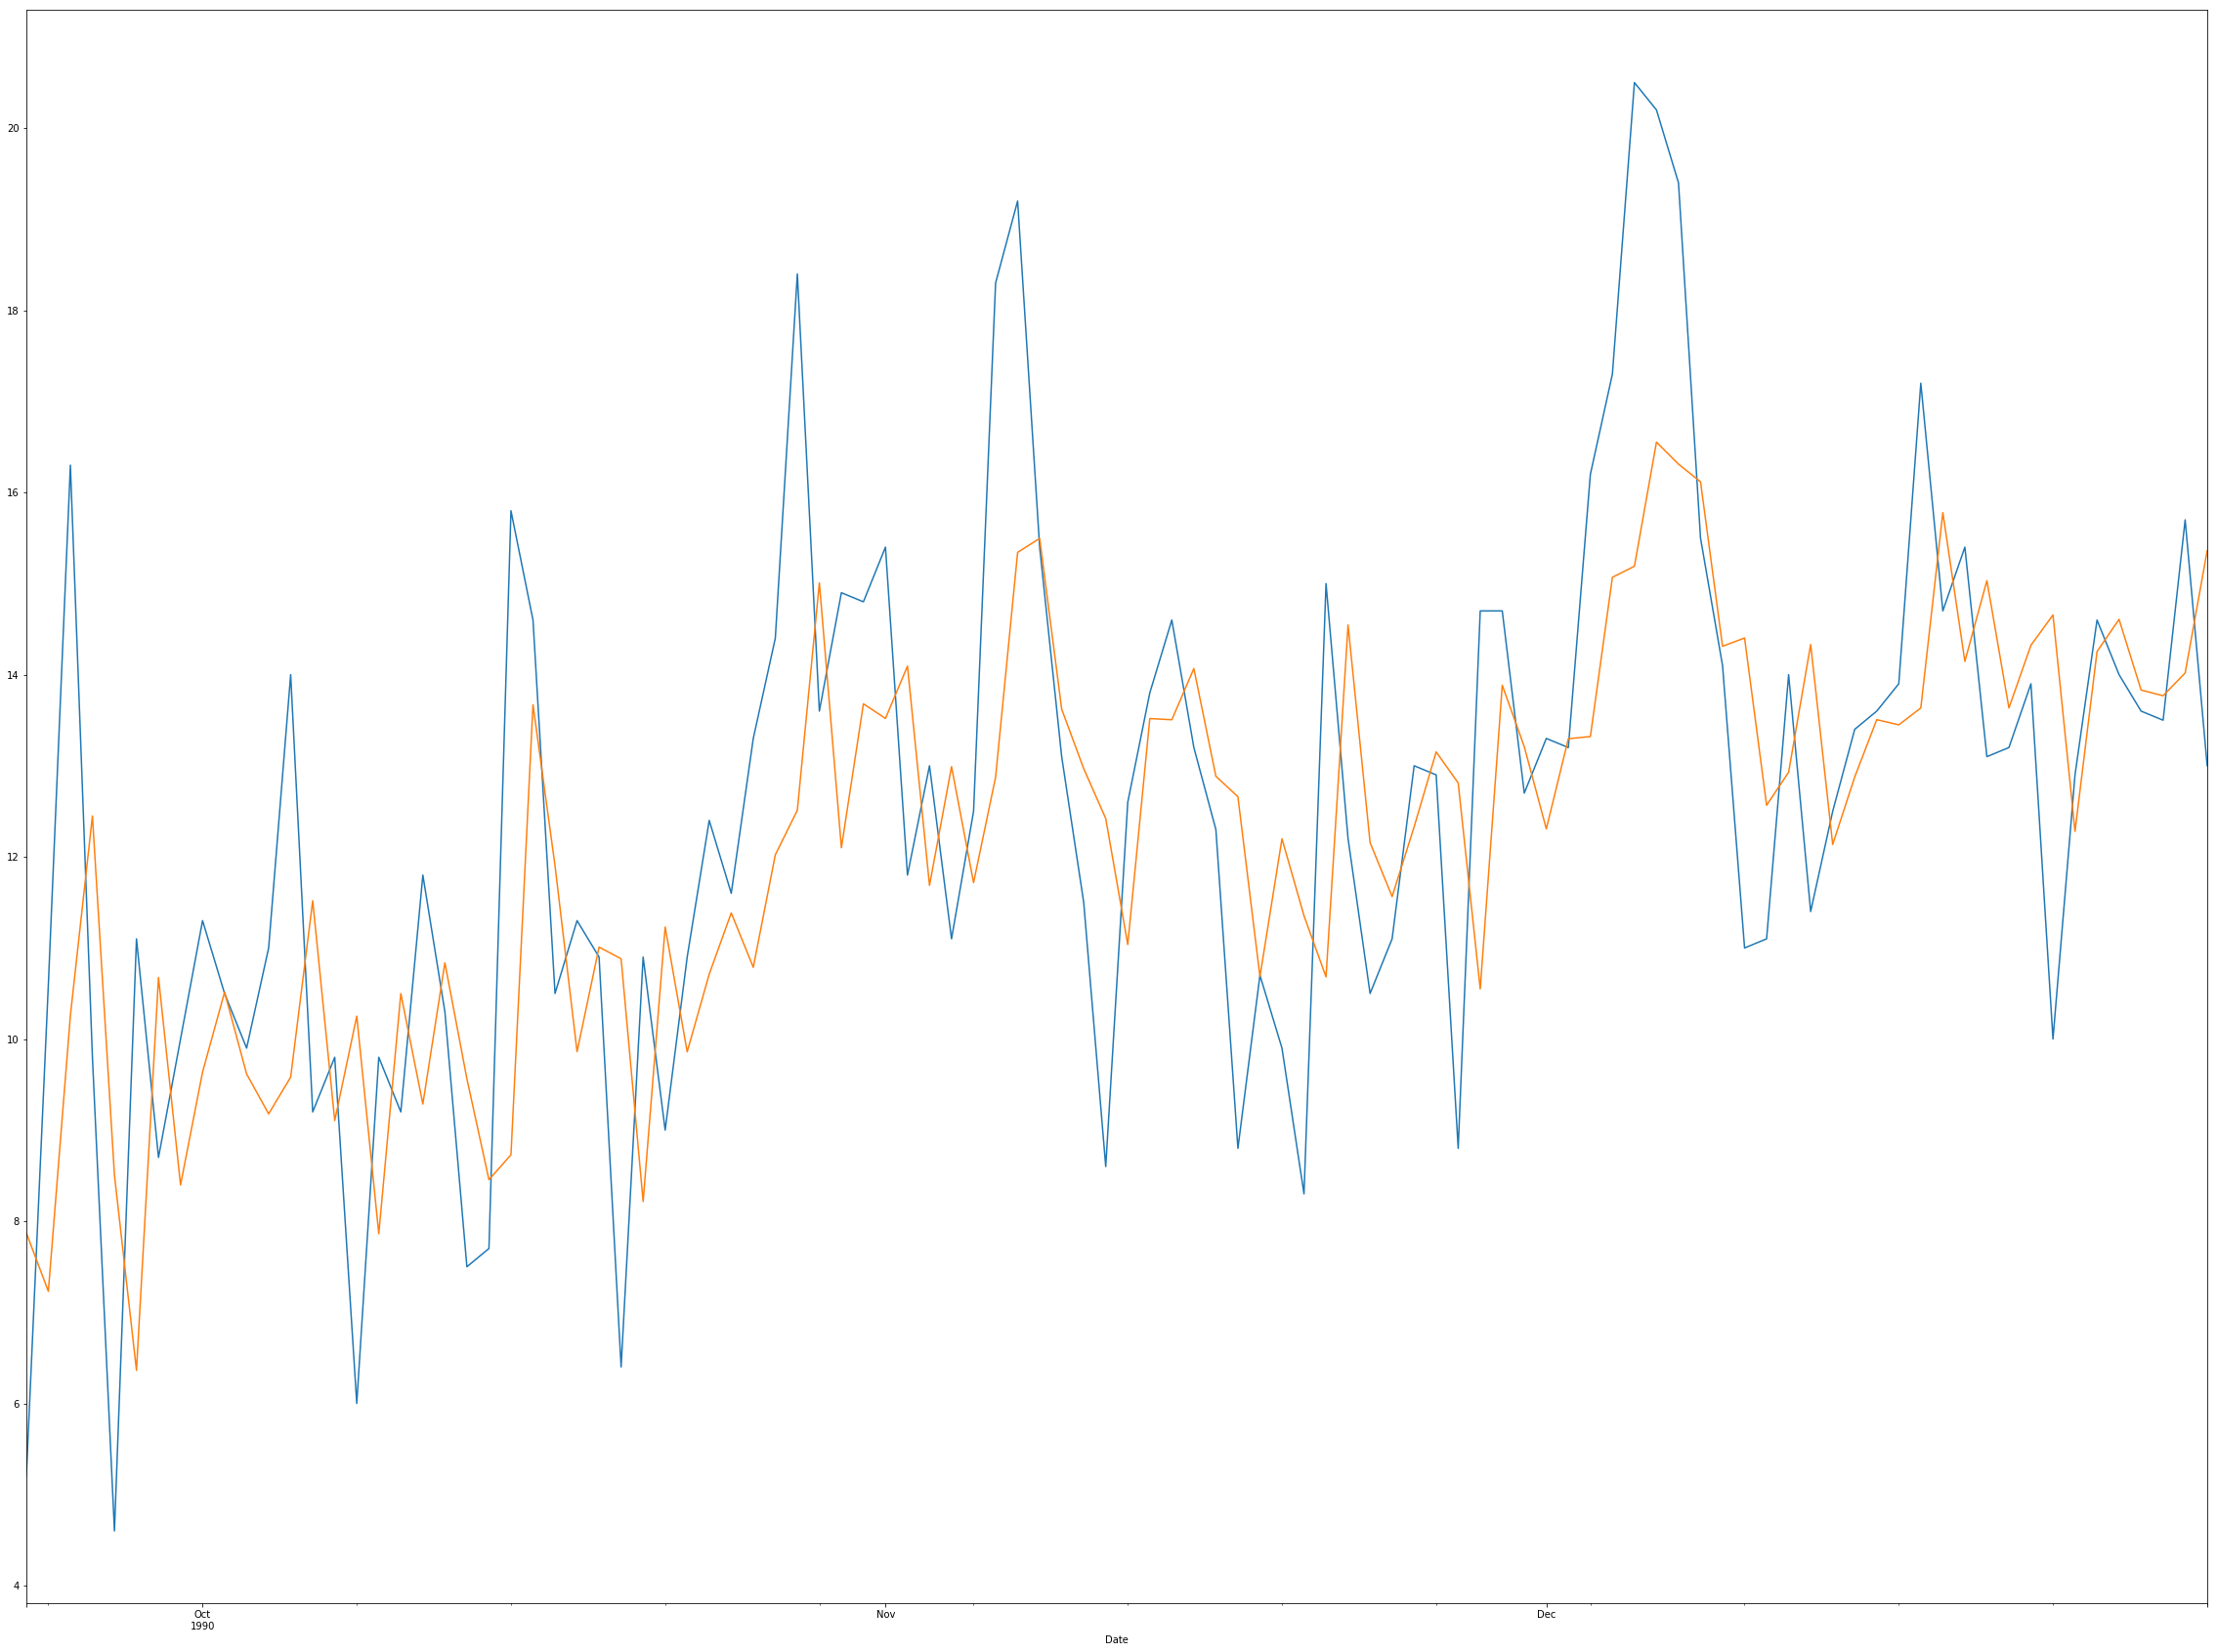

In [236]:
analyze(model)

In [237]:
def analyze(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred, y_test.index)
    print(r2_score(y_test, y_pred))
    y_test[-100:].plot(figsize=(40, 30))
    y_pred[-100:].plot(figsize=(40, 30))

In [238]:
from sklearn.ensemble import GradientBoostingRegressor

In [239]:
model_boost = GradientBoostingRegressor(n_estimators=70, max_depth=3)

0.6843114038514506


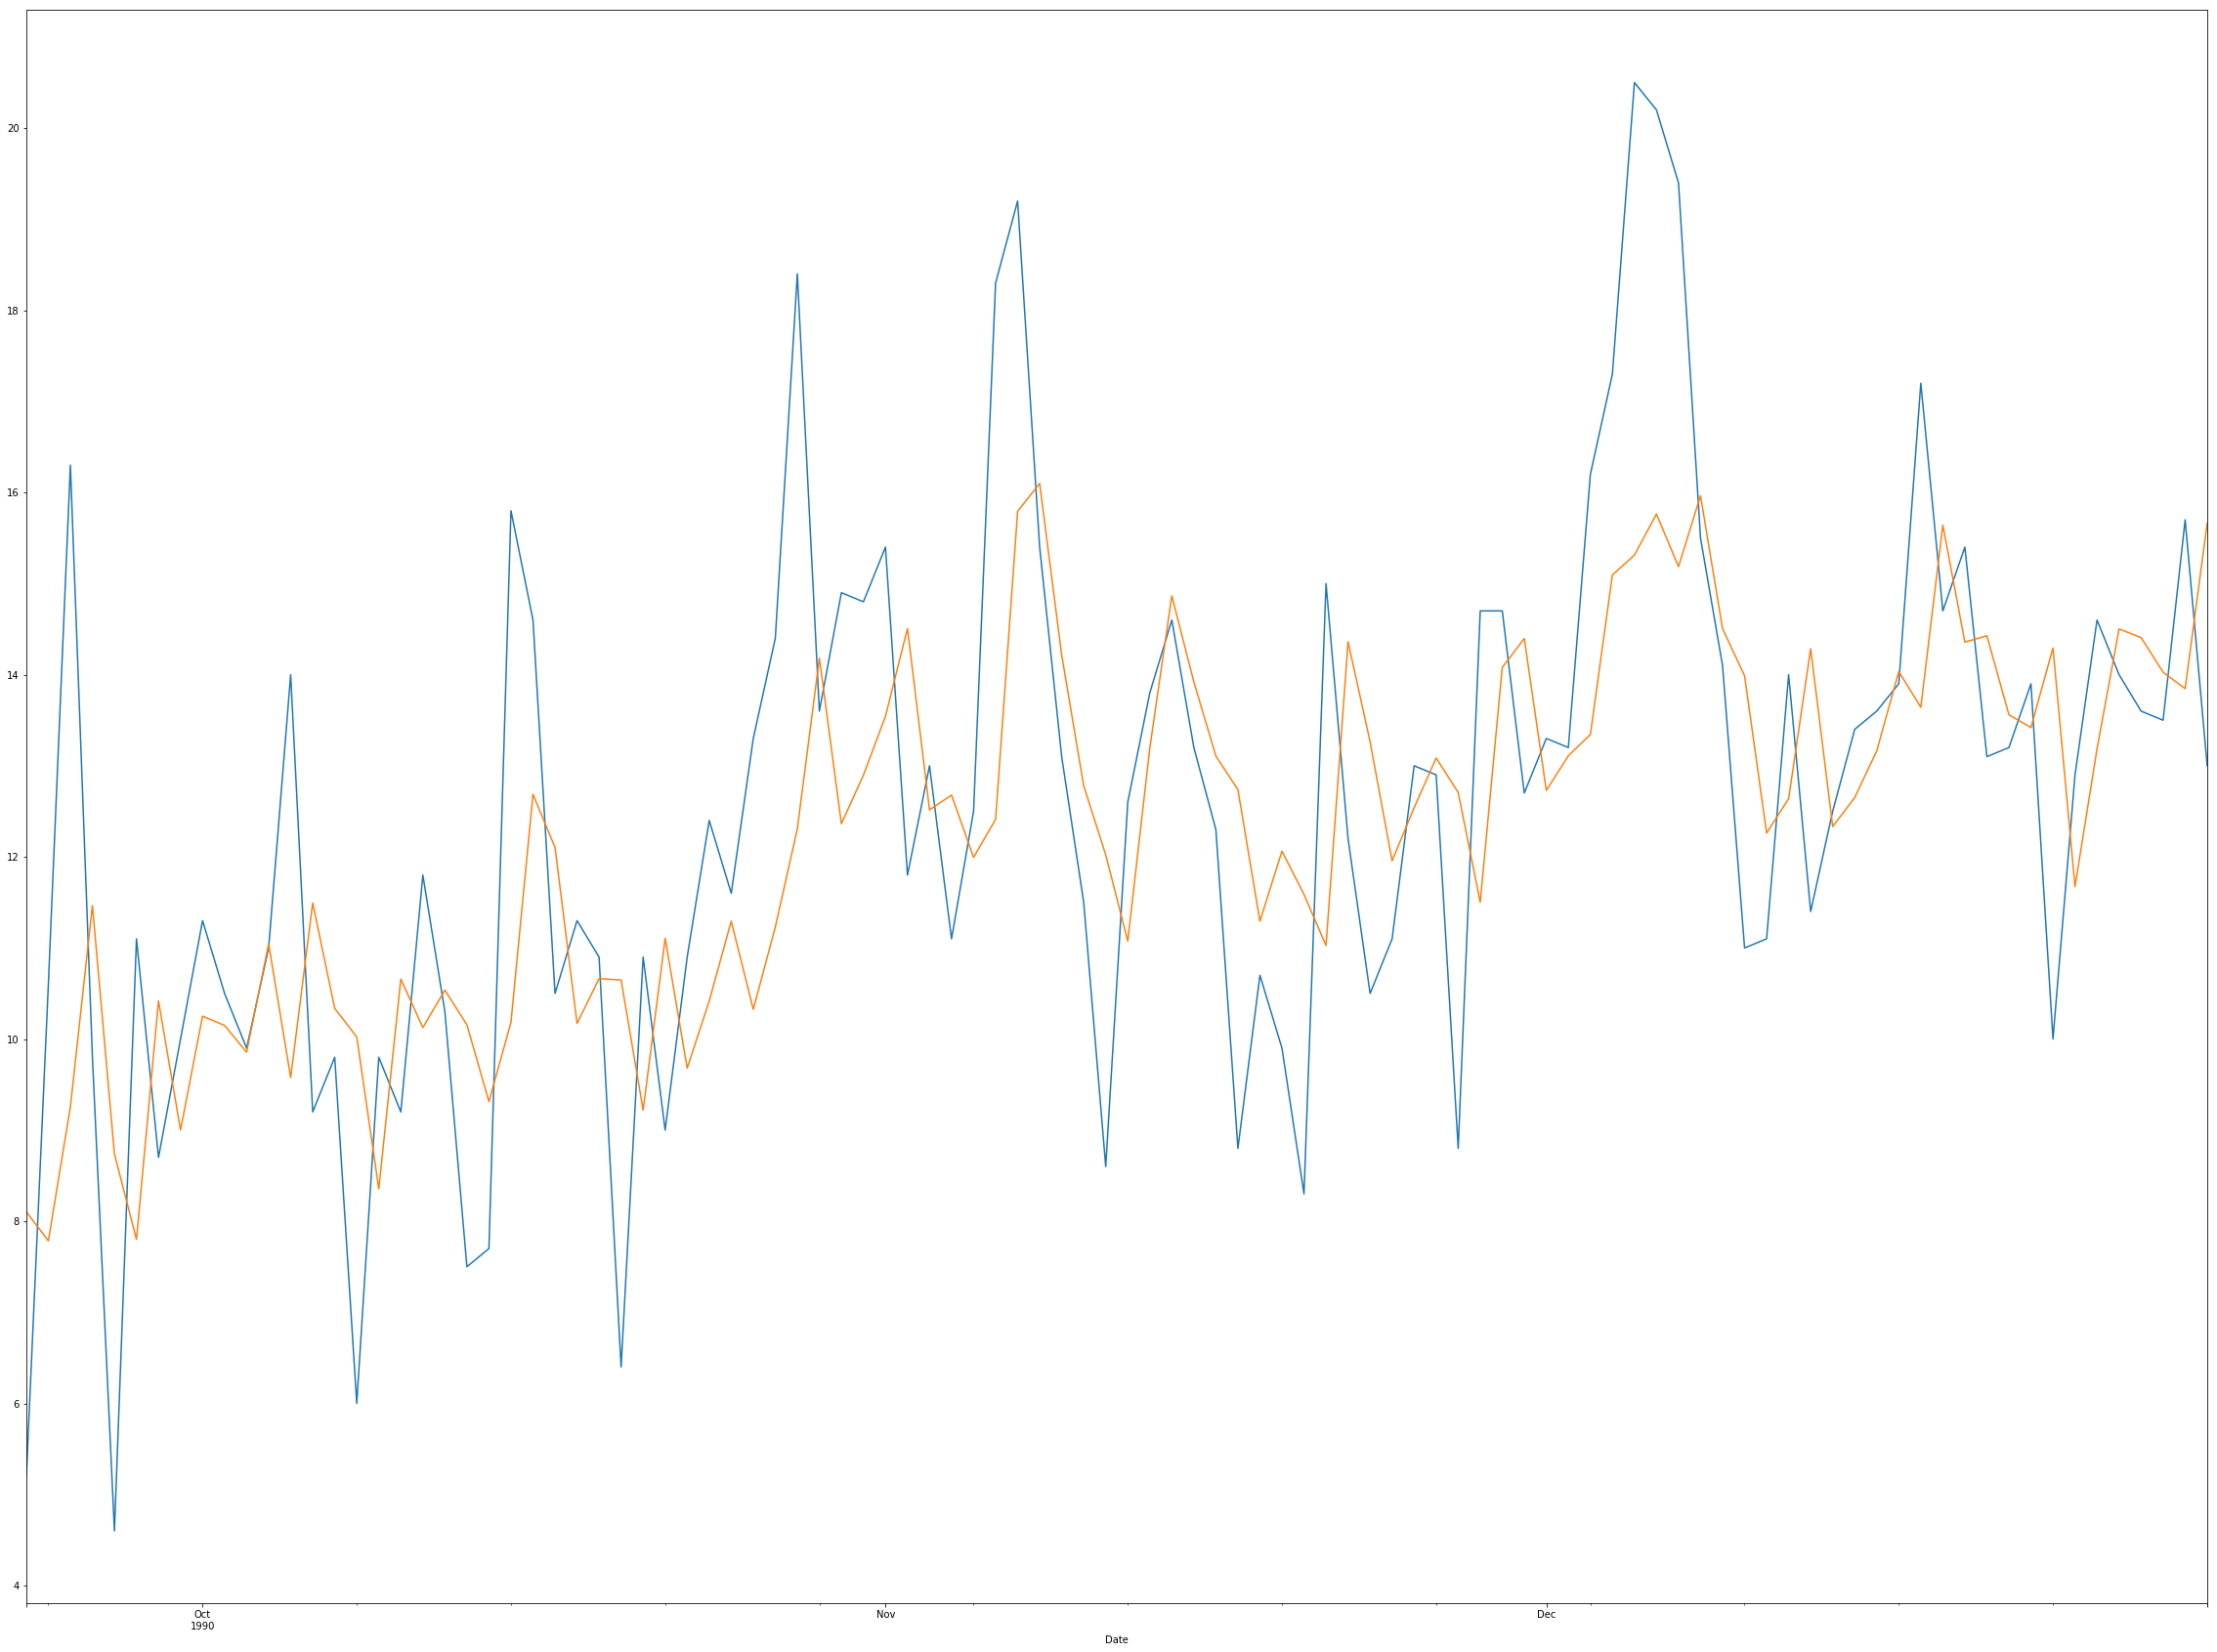

In [240]:
analyze(model_boost)

In [223]:
from sklearn.model_selection import GridSearchCV

In [224]:
param_grid = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.1, 0.01, 1],
    'max_depth': [3, 5, 7]
}

In [225]:
from sklearn.model_selection import TimeSeriesSplit

In [226]:
splitter = TimeSeriesSplit(5)

In [227]:
model_grid  = GradientBoostingRegressor()

In [228]:
grid = GridSearchCV(
    model_grid,
    param_grid,
    cv = splitter
)

In [229]:
grid.fit(X_train, y_train)

KeyboardInterrupt: 

0.6806373768999151


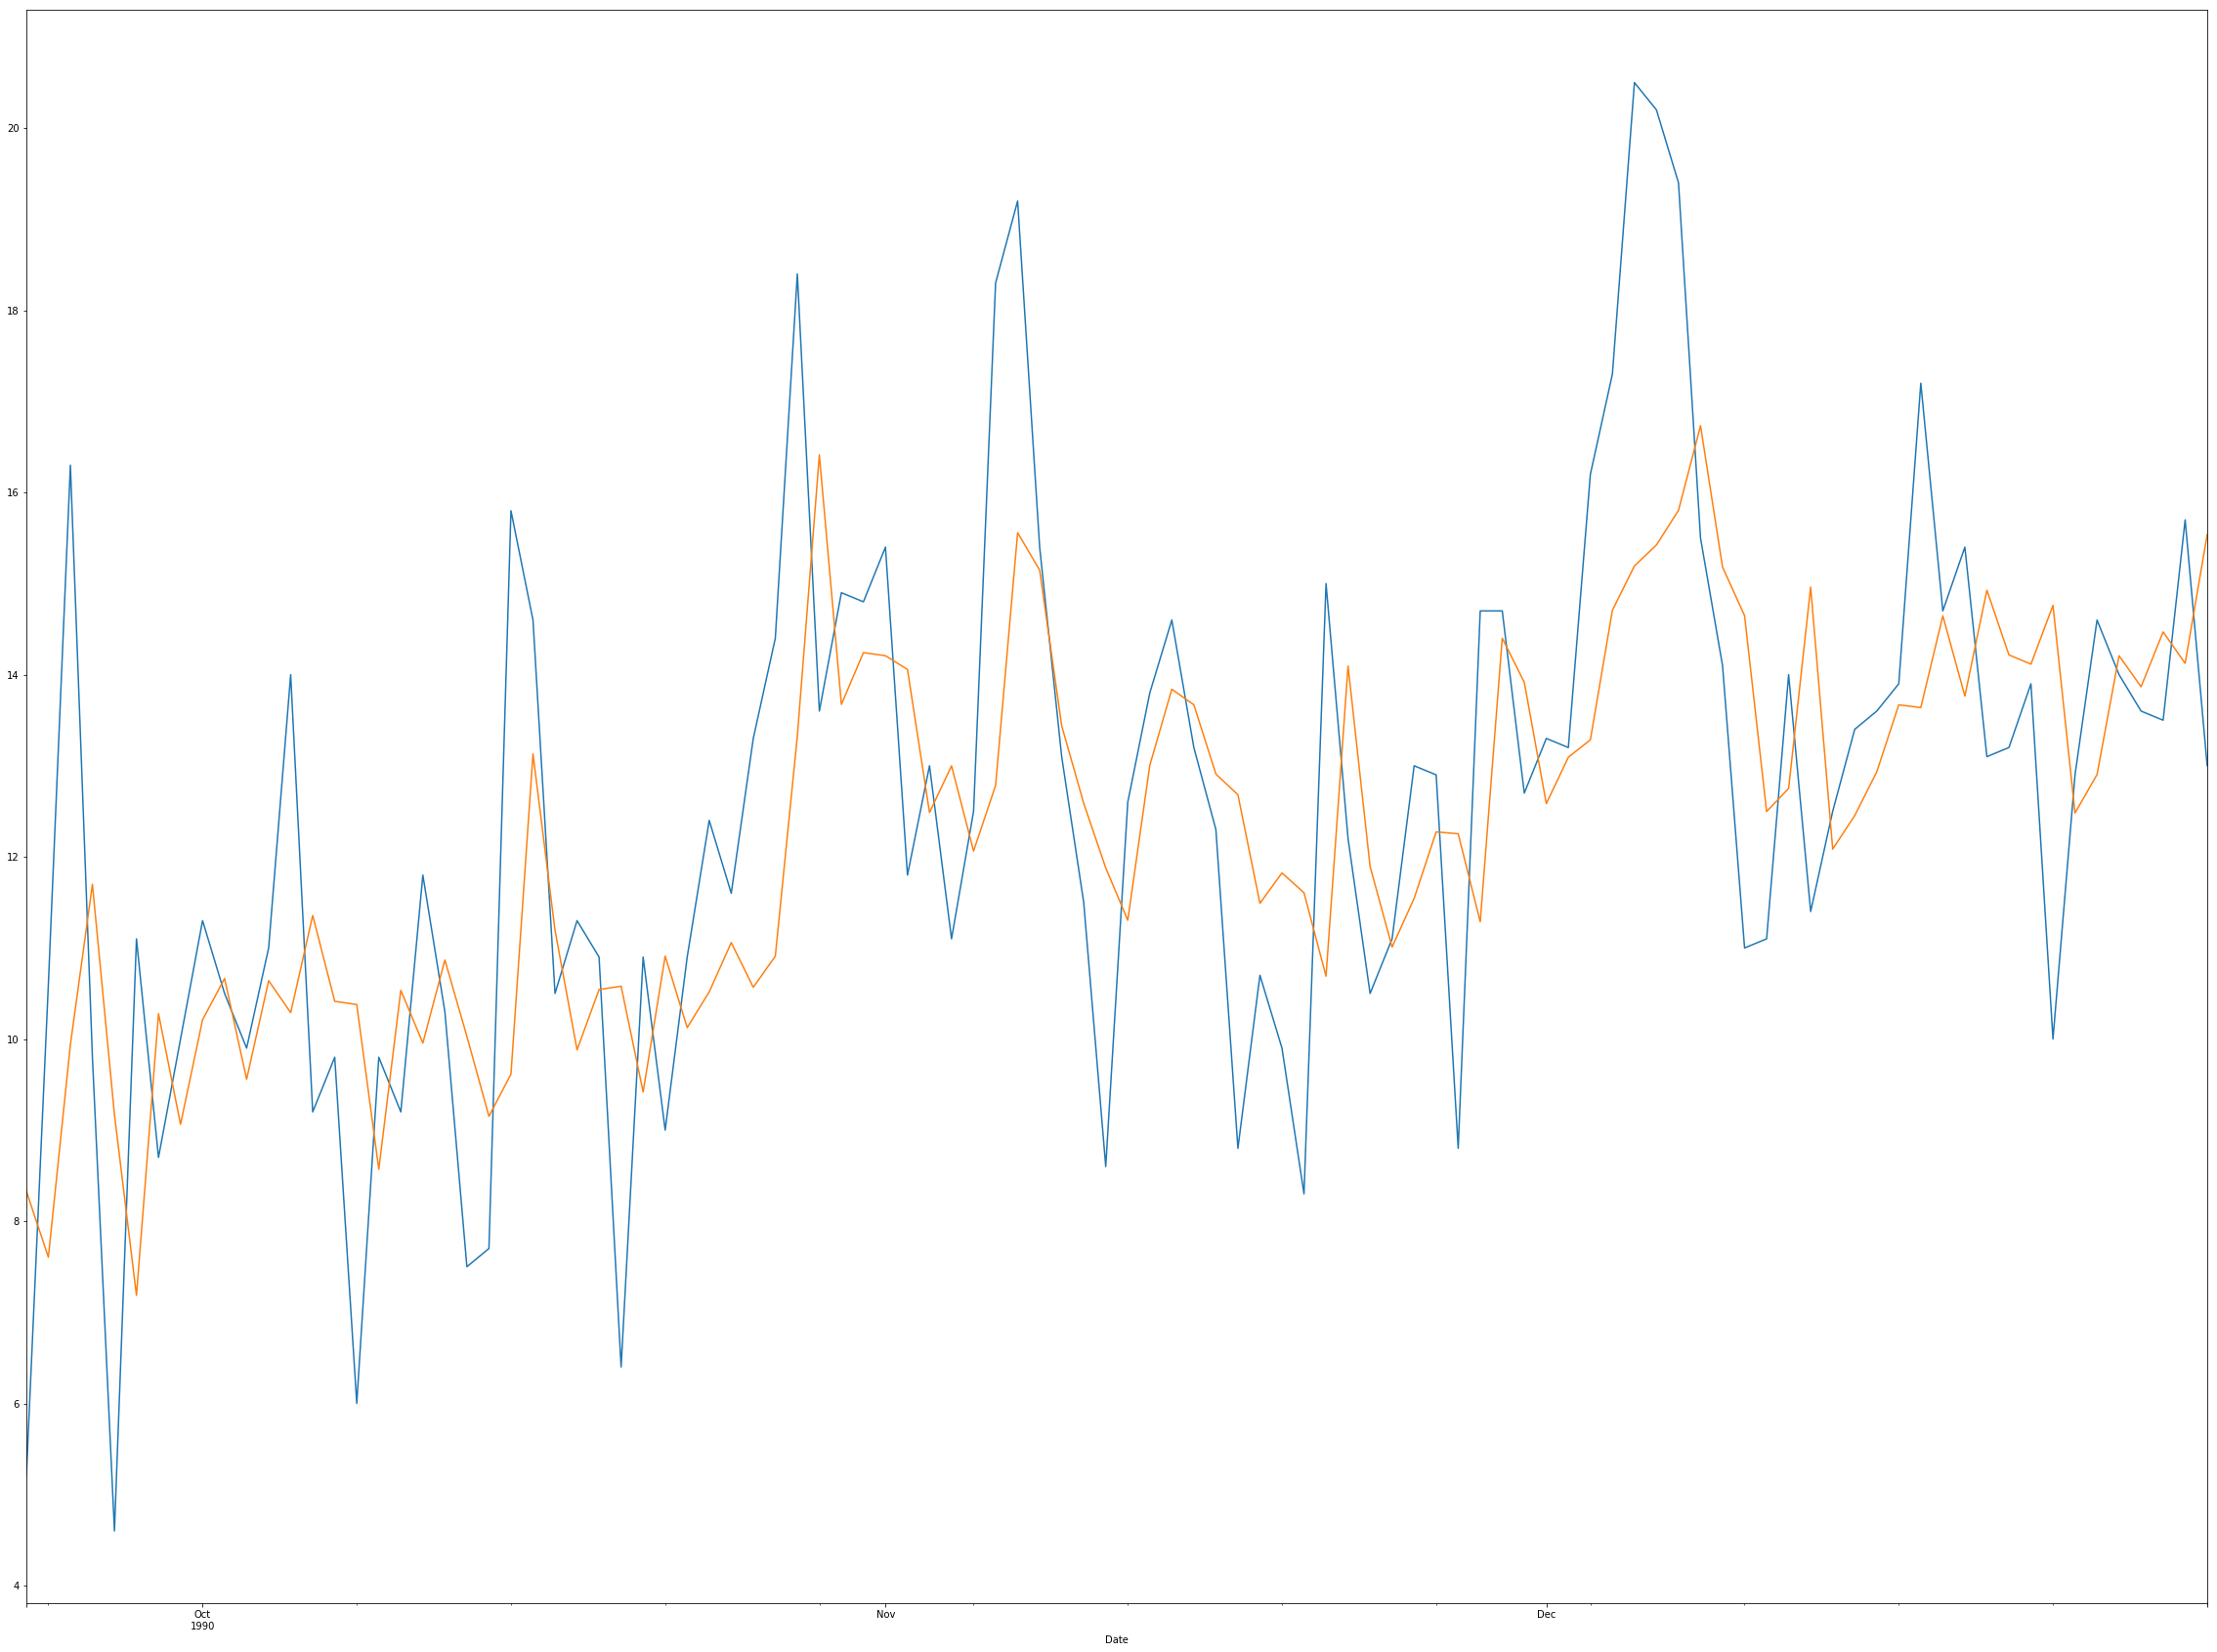

In [206]:
y_pred = grid.predict(X_test)
y_pred = pd.Series(y_pred, y_test.index)
print(r2_score(y_test, y_pred))
y_test[-100:].plot(figsize=(40, 30))
y_pred[-100:].plot(figsize=(40, 30))